# Part 0: Setup model and download pretrained weights

In [1]:
#@title Setup model

import os

# %pip install pydrive --upgrade
# %pip install gdown
# os.chdir('/content')
# !wget https://github.com/arash-mham/visual-computing-II/raw/main/assignments/A4-StyleGAN/stylegan2.zip
# !unzip stylegan2.zip

# !wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
# !sudo unzip ninja-linux.zip -d /usr/local/bin/
# !sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

In [2]:
#@title import modules
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

# %pip install -q ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



#this part might take a while
from stylegan2.model import Generator

In [3]:
#download checkpoint
#ignore warning of deprecated pydrive


#@title Setup checkpoint downloader
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True

CODE_DIR = ''
class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive
        current_directory = os.getcwd()
        self.save_dir = os.path.join(current_directory, CODE_DIR, "pretrained_models")
        os.makedirs(self.save_dir, exist_ok=True)
        print(self.save_dir)

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_name):
        file_dst = f'{self.save_dir}/{file_name}'
        if os.path.exists(file_dst):
            print(f'{file_name} already exists!')
            return
        if self.use_pydrive:
            self.authenticate()
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)
id = '1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT'
file_name = 'stylegan2-ffhq-config-f.pt'

downloader.download_file(id, file_name)

ModuleNotFoundError: No module named 'google.colab'

# Part 1: Image generation with StyleGAN2

In [4]:
class Generator_Wrapper:
  def __init__(self):
    #initialize model
    self.model = Generator(1024, 512, 8).to('cuda')
    #load pretrained weights to the generator
    self.init_weights()
    #Generator generates images of resolution 1024x1024. To downsample the images, we apply average pooling to bring it to the resolution 256x256
    self.face_pool = torch.nn.AdaptiveAvgPool2d((256, 256))
  def init_weights(self):
    self.model.load_state_dict(torch.load('./pretrained_models/stylegan2-ffhq-config-f.pt')['g_ema'])
  def requires_grad(self,model, flag=True):
    for p in model.parameters():
      p.requires_grad = flag
  def print_grad(self,model):
    for name,parameters in model.named_parameters():
      print(name,':',parameters.requires_grad)
  def generate_image(self, input = None, input_is_latent = False, num_images = 1,is_train=False):
    #input: if None you should generate the z latent code. z should be of size (num_images, 512)
    #input_is_latent: if input is not None, it means that we are providing the latent code to the function. If the latent code is in the Z space input_is_latent should be False. If the latent code is in the W space the input_is_latent should be True
    #num_images: number of images that we want to generate

    #returns: output images with size (num_images, 3, 256, 256)
    #returns: latent codes in the W space with size (num_images, 18, 512)
    if input is None:
      #TODO: generate random z codes
      input = torch.randn(num_images, 512).to('cuda')
    if is_train:
      self.requires_grad(self.model, True)
    else:
      self.requires_grad(self.model, False)
    # with torch.no_grad():
    #TODO: use the Generator to generate images and output latents
    if input_is_latent:
      out, latents = self.model([input], input_is_latent=True, return_latents=True)
    else:
      out, latents = self.model([input], return_latents=True)
    #TODO: downsample the images with the average pooling module
    out = self.face_pool(out)

    return out, latents

  def tensor2image(self,out):

    out = (out + 1) / 2

    out = out.clamp(0, 1)

    out = out.permute(0, 2, 3, 1).cpu().numpy()

    out = np.concatenate(np.split(out, out.shape[0], axis=0), axis=2)

    out = np.squeeze(out)

    out = (out * 255).astype(np.uint8)

    image = Image.fromarray(out)

    return image

In [5]:
G = Generator_Wrapper()
images, latents = G.generate_image(num_images = 8)

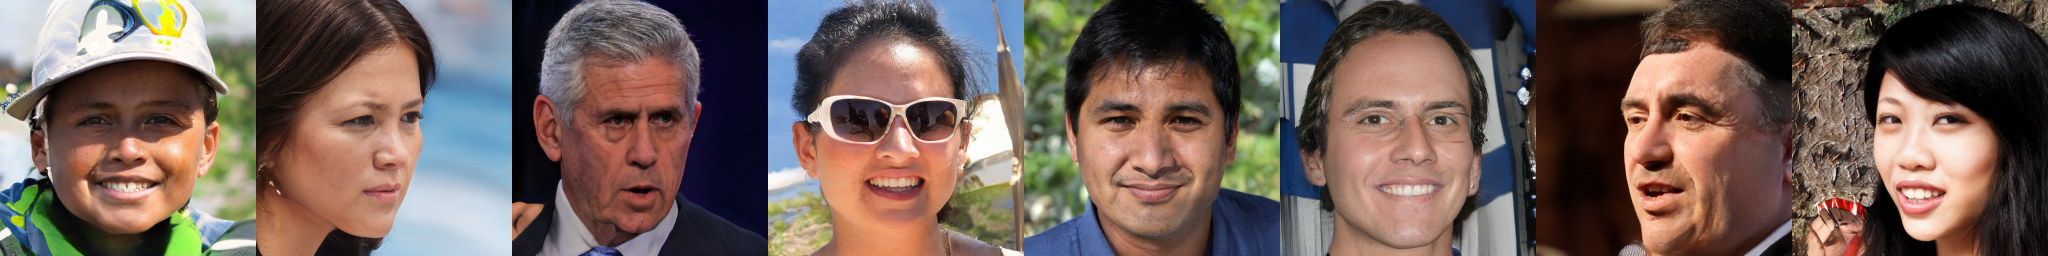

In [6]:
G.tensor2image(images)

# Part 2: Latent interpolation

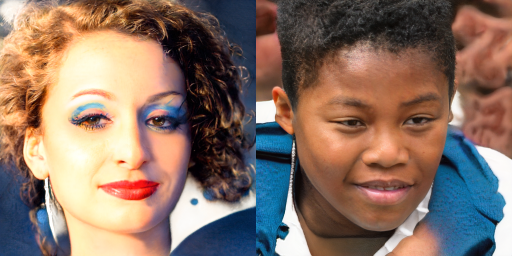

In [7]:
#TODO: generate two images and visualize

images, interpolation_latents = G.generate_image(num_images = 2)
G.tensor2image(images)

In [57]:
#interpolate two latents
def interpolate_latents(latents,interpolate_scale):
  #TODO: interpolate between two latents generated above. interpolate_scale (r) is the interpolation coefficient
  new_latent = latents[0] * interpolate_scale + latents[1] * (1 - interpolate_scale)
  new_latent = new_latent.unsqueeze(0)
  image_new, latent_new = G.generate_image(input=new_latent,input_is_latent=True)
  image_new = G.tensor2image(image_new)
  return image_new

In [9]:
#make slider and visualize
interact(interpolate_latents, latents=fixed(interpolation_latents),interpolate_scale=widgets.FloatSlider(0.5, min=0, max=1., step=0.05))

interactive(children=(FloatSlider(value=0.5, description='interpolate_scale', max=1.0, step=0.05), Output()), …

<function __main__.interpolate_latents(latents, interpolate_scale)>

#Part 3: Latent Mixing

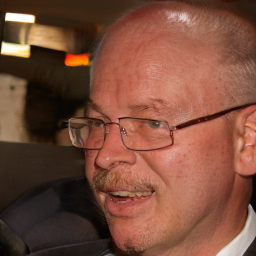

In [10]:
#TODO: make a base image with latents and visualize
base_image, base_latents = G.generate_image(num_images = 1)
G.tensor2image(base_image)

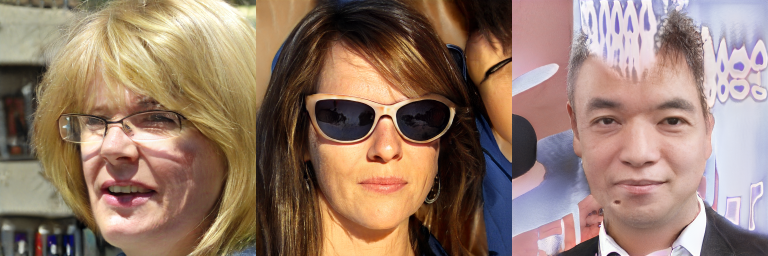

In [11]:
#TODO: make 3 new faces. They will be edited using base latent
editing_images, editing_latents = G.generate_image(num_images = 3)
G.tensor2image(editing_images)

In [12]:
def mix_latents(base_latents,editing_latents,mixing_point):
  #TODO: mix latents. the first mixing_point blocks should get the latent from base_latent and the rest come from editing_latents
  mixed_latents = []

  for i in range(editing_latents.shape[0]):
      mixed_latent = torch.cat((base_latents[0][:mixing_point, :], editing_latents[i, mixing_point:, :]))
      mixed_latents.append(mixed_latent)

  mixed_latents = torch.stack(mixed_latents)
  with torch.no_grad():
    ret_edited_images,ret_edited_latents = G.generate_image(input=mixed_latents,input_is_latent=True)
  return G.tensor2image(ret_edited_images)


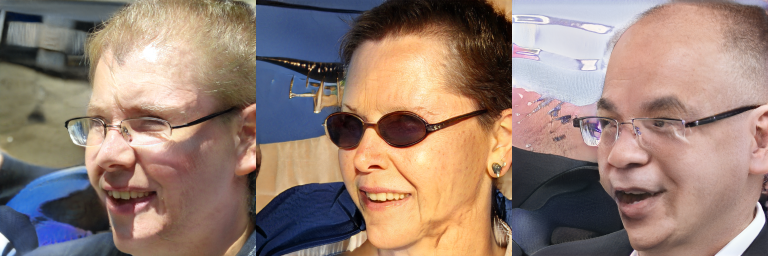

In [13]:
mix_images = mix_latents(base_latents,editing_latents,5)
mix_images

In [14]:
interact(mix_latents,
      base_latents = fixed(base_latents),
      editing_latents = fixed(editing_latents),
      mixing_point=widgets.IntSlider(5, min=0, max=18, step=1))

interactive(children=(IntSlider(value=5, description='mixing_point', max=18), Output()), _dom_classes=('widget…

<function __main__.mix_latents(base_latents, editing_latents, mixing_point)>

# Part 4: StyleGAN inversion

In [ ]:
#@title download image alignment library and landmarks
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2


In [ ]:
#@title download image to invert
!wget https://github.com/arash-mham/visual-computing-II/blob/main/assignments/A4-StyleGAN/image.jpg?raw=true -O image.jpg

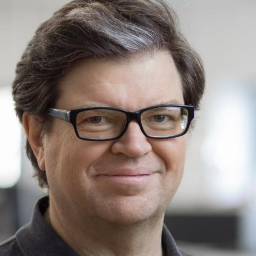

In [15]:
#run alignment on image
from stylegan2.alignment import align_face
import dlib

predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
aligned_image = align_face('image.jpg', predictor=predictor)
aligned_image

In [16]:
#load latent average for good initialization
average_latent = torch.load('./pretrained_models/stylegan2-ffhq-config-f.pt')['latent_avg']

In [17]:
#TODO: follow the assignment document to complete this part
print(average_latent.shape)

torch.Size([512])


In [ ]:
!pip install lpips

In [18]:
import torch.optim as optim
from torchvision.transforms import ToTensor
import lpips

latent_dim = 512
batch_size = 1
num_latents = 18  # W+ space

perceptual_loss_fn = lpips.LPIPS(net='alex').to('cuda')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


C:\Users\sh199\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\sh199\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: C:\Users\sh199\AppData\Roaming\Python\Python38\site-packages\lpips\weights\v0.1\alex.pth


In [19]:
num_steps = 1000
lambda_lpips = 10
use_W_plus = False
use_LPIPS = False
G = Generator_Wrapper()

In [39]:
def styleGAN_inverse(image,lr=0.002):

  if use_W_plus:
    initial_latent = average_latent.unsqueeze(0).unsqueeze(0).expand(batch_size,num_latents ,latent_dim)
  else:
    initial_latent = average_latent.unsqueeze(0).expand(batch_size, latent_dim)

  initial_latent = initial_latent.clone().detach()

  initial_latent = initial_latent.to('cuda').requires_grad_(True)

  generated_image = []

  optimizer = optim.NAdam([initial_latent], lr=lr)
  loss_fn = torch.nn.MSELoss()
  for step in range(num_steps):
    optimizer.zero_grad()

    generated_image,generated_latent = G.generate_image(input=initial_latent,input_is_latent=True,is_train=False)
    # generated_image = (generated_image + 1.0) / 2.0
    loss = loss_fn(generated_image, image)

    if use_LPIPS:
      loss += float(lambda_lpips * perceptual_loss_fn(generated_image, image))
    loss.backward()
    optimizer.step()

    if step % 100 == 0 or step == num_steps-1:
      print(f"Step {step}, Loss: {loss.item()}")
  return generated_image,generated_latent

In [38]:
num_steps = 1000
use_W_plus = False
transforms_ = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

aligned_tensor = transforms_(aligned_image).unsqueeze(0).to('cuda')

In [65]:
# Use MSE
generated_image,_ = styleGAN_inverse(aligned_tensor)

Step 0, Loss: 1.6556181907653809
Step 100, Loss: 0.7661392688751221
Step 200, Loss: 0.6838539242744446
Step 300, Loss: 0.6404240131378174
Step 400, Loss: 0.6071413159370422
Step 500, Loss: 0.5871343016624451
Step 600, Loss: 0.5538822412490845
Step 700, Loss: 0.5454153418540955
Step 800, Loss: 0.5379364490509033
Step 900, Loss: 0.5316815972328186
Step 1000, Loss: 0.5286223888397217
Step 1100, Loss: 0.5369128584861755
Step 1200, Loss: 0.5433998107910156
Step 1300, Loss: 0.5571000576019287
Step 1400, Loss: 0.5805197358131409
Step 1499, Loss: 0.5860976576805115


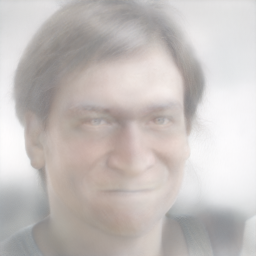

In [66]:
G.tensor2image(generated_image.detach().cpu())

In [67]:
# Use w+
num_steps = 1000
use_W_plus = True
generated_image_w_plus,_ = styleGAN_inverse(aligned_tensor)

Step 0, Loss: 1.6742398738861084
Step 100, Loss: 0.7584363222122192
Step 200, Loss: 0.6904081106185913
Step 300, Loss: 0.6420114636421204
Step 400, Loss: 0.6143798232078552
Step 500, Loss: 0.5688411593437195
Step 600, Loss: 0.5530439615249634
Step 700, Loss: 0.5362527966499329
Step 800, Loss: 0.5392106771469116
Step 900, Loss: 0.5315883755683899
Step 999, Loss: 0.5296961665153503


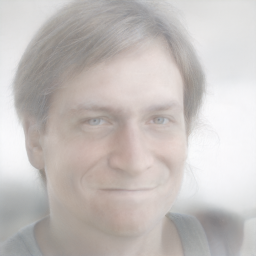

In [68]:
G.tensor2image(generated_image_w_plus.detach().cpu())

In [69]:
# Use MSE + LPIPS
num_steps = 1500
lambda_lpips = 2
use_W_plus = True
use_LPIPS = True
generated_image_LPIPS,generated_latents_LPIPS = styleGAN_inverse(aligned_tensor,lr=0.01)

Step 0, Loss: 1.6615678071975708
Step 100, Loss: 0.6150650978088379
Step 200, Loss: 0.5592385530471802
Step 300, Loss: 0.5639240741729736
Step 400, Loss: 0.5914373993873596
Step 500, Loss: 0.5904104709625244
Step 600, Loss: 0.6049646139144897
Step 700, Loss: 0.6111881732940674
Step 800, Loss: 0.6194647550582886
Step 900, Loss: 0.5942779779434204
Step 1000, Loss: 0.5986896753311157
Step 1100, Loss: 0.5992431044578552
Step 1200, Loss: 0.5905611515045166
Step 1300, Loss: 0.5877974033355713
Step 1400, Loss: 0.5764661431312561
Step 1499, Loss: 0.5705533623695374


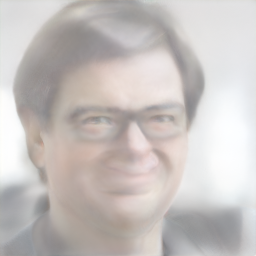

In [70]:
G.tensor2image(generated_image_LPIPS.detach().cpu())

In [61]:
# Bonus
base_image, base_latents = G.generate_image(num_images = 1)
latents = torch.cat([generated_latents_LPIPS,base_latents],dim=0).detach()
assert latents.shape != ([2, 18, 512])
interact(interpolate_latents, latents=fixed(latents),interpolate_scale=widgets.FloatSlider(0.5, min=0, max=1., step=0.05))

interactive(children=(FloatSlider(value=0.5, description='interpolate_scale', max=1.0, step=0.05), Output()), …

<function __main__.interpolate_latents(latents, interpolate_scale)>

In [64]:
editing_images, editing_latents = G.generate_image(num_images = 3)
interact(mix_latents,
      base_latents = fixed(generated_latents_LPIPS),
      editing_latents = fixed(editing_latents),
      mixing_point=widgets.IntSlider(5, min=0, max=18, step=1))

interactive(children=(IntSlider(value=5, description='mixing_point', max=18), Output()), _dom_classes=('widget…

<function __main__.mix_latents(base_latents, editing_latents, mixing_point)>